In [3]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.ticker as ticker
from IPython.display import Image, display



# Define the current directory and add it to the system path
current_dir = os.getcwd()
current_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(current_dir)

print('Current directory: ', current_dir)
print()

image_path = os.path.join(current_dir, 'figures', 'diagram.png')
plt.rcParams['font.family'] = 'Times New Roman'

from src.utils.statistics import describe_data, fill_outliers
from src.utils.visualization import tplot, descplot, descplot_2

Current directory:  c:\Users\maria\OneDrive\Documentos\Github\Condition-monitoring-of-hydraulic-systems-Data-Set



## Understanding the dataset

The data set was experimentally obtained using a hydraulic test rig. This test rig consists of a primary working circuit and a secondary cooling-filtration circuit connected via the oil tank. The system cyclically repeats constant load cycles (duration 60 seconds) and measures process values such as pressures, volume flows, and temperatures while the condition of four hydraulic components (cooler, valve, pump, and accumulator) is quantitatively varied.

Attribute Information
The data set contains raw process sensor data structured with the rows representing the cycles and the columns representing the data points within a cycle. All sensors were oversampled in the ETL file and now have a uniform sampling rate of 100 Hz. The sensors involved are show in the diagram bellow:

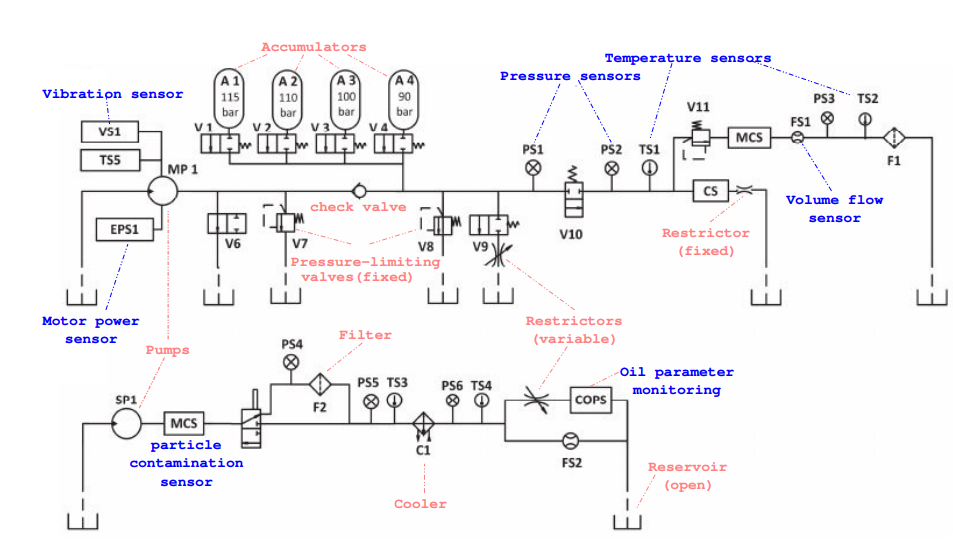

In [4]:
display(Image(filename=image_path, width=800))

### Objective
The objective of this analysis is to monitor internal pump leakage (MP1), which can be classified into three categories:
- 0: No leakage
- 1: Weak leakage
- 2: Severe leakage

The target condition values are cycle-wise annotated in the `profile.txt` file.

## Read data

In [5]:
data_dir = os.path.join(current_dir, 'data','processed','etl')

# List of sensor file names
sensores_list = ['PS1','PS2','PS3','PS4','PS5','PS6',
                 'EPS1','FS1','FS2',
                 'TS1','TS2','TS3','TS4',
                 'VS1','CE','CP','SE','profile']

# Dictionary to store the data
X_dict = {}

# Load sensor data from parquet files
for s in tqdm(sensores_list, desc="Loading sensor data"):
    file_path = os.path.join(data_dir, s + '.parquet')
    X_dict[s] = pd.read_parquet(file_path)

# Just to check the loaded data
for sensor, data in X_dict.items():
    print(f"{sensor} data shape: {data.shape}")

Loading sensor data:   0%|          | 0/18 [00:00<?, ?it/s]

Loading sensor data: 100%|██████████| 18/18 [00:06<00:00,  2.99it/s]

PS1 data shape: (2205, 6000)
PS2 data shape: (2205, 6000)
PS3 data shape: (2205, 6000)
PS4 data shape: (2205, 6000)
PS5 data shape: (2205, 6000)
PS6 data shape: (2205, 6000)
EPS1 data shape: (2205, 6000)
FS1 data shape: (2205, 6000)
FS2 data shape: (2205, 6000)
TS1 data shape: (2205, 6000)
TS2 data shape: (2205, 6000)
TS3 data shape: (2205, 6000)
TS4 data shape: (2205, 6000)
VS1 data shape: (2205, 6000)
CE data shape: (2205, 6000)
CP data shape: (2205, 6000)
SE data shape: (2205, 6000)
profile data shape: (2205, 5)


## Check Null values 

In [6]:
for k, v in X_dict.items():
    print('how nan ' + str(k) + ' = ' + str((X_dict[k].isnull().sum(axis=1) != 0).sum()))

how nan PS1 = 0
how nan PS2 = 0
how nan PS3 = 0
how nan PS4 = 0
how nan PS5 = 0
how nan PS6 = 0
how nan EPS1 = 0
how nan FS1 = 0
how nan FS2 = 0
how nan TS1 = 0
how nan TS2 = 0
how nan TS3 = 0
how nan TS4 = 0
how nan VS1 = 0
how nan CE = 0
how nan CP = 0
how nan SE = 0
how nan profile = 0


In [7]:
X_dict['profile'].rename(columns={'2': 'profile'}, inplace=True)
X_profile = X_dict['profile']['profile']
X_profile = pd.DataFrame(X_profile)

if 'profile' in X_dict:
    del X_dict['profile']

In [ ]:
for c, u in zip(X_dict.keys(), ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)','Power (W)',
                                'Flow Rate (L/min)', 'Flow Rate (L/min)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)','Vibration (mm/s)', 'Cooler Efficiency (%)', 'Cooler Power (kW)', 'Efficiency Factor (%)']):
    tplot(X_dict[c], c, u)

- Observing the boxplots above, we can infer that the pressure variables exhibit numerous outliers. This is evident as they vary across a wide range, which is not typical behavior for pressure measurements.

## Remove outliers

In [8]:
for k, v in X_dict.items():
    X_dict[k] = fill_outliers(v, k, c = 2.5)

how outliers PS1 = 0
how outliers PS2 = 2782502
how outliers PS3 = 3012397
how outliers PS4 = 0
how outliers PS5 = 0
how outliers PS6 = 0
how outliers EPS1 = 0
how outliers FS1 = 3235200
how outliers FS2 = 0
how outliers TS1 = 0
how outliers TS2 = 0
how outliers TS3 = 0
how outliers TS4 = 0
how outliers VS1 = 164100
how outliers CE = 0
how outliers CP = 0
how outliers SE = 2558200


In [ ]:
for c, u in zip(X_dict.keys(), ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)','Power (W)',
                                'Flow Rate (L/min)', 'Flow Rate (L/min)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)','Vibration (mm/s)', 'Cooler Efficiency (%)', 'Cooler Power (kW)', 'Efficiency Factor (%)']):
    tplot(X_dict[c], c, u)

Since we have multiple measurements per time instance, let's compute statistical metrics for each measurement (row)

In [9]:
# Get the descriptive statistics
for k, v in X_dict.items():
    X_dict[k] = describe_data(v)

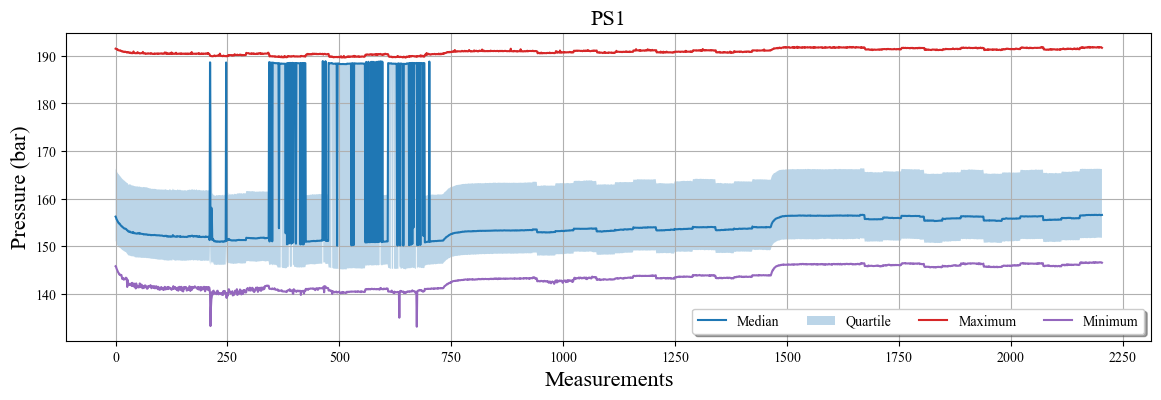

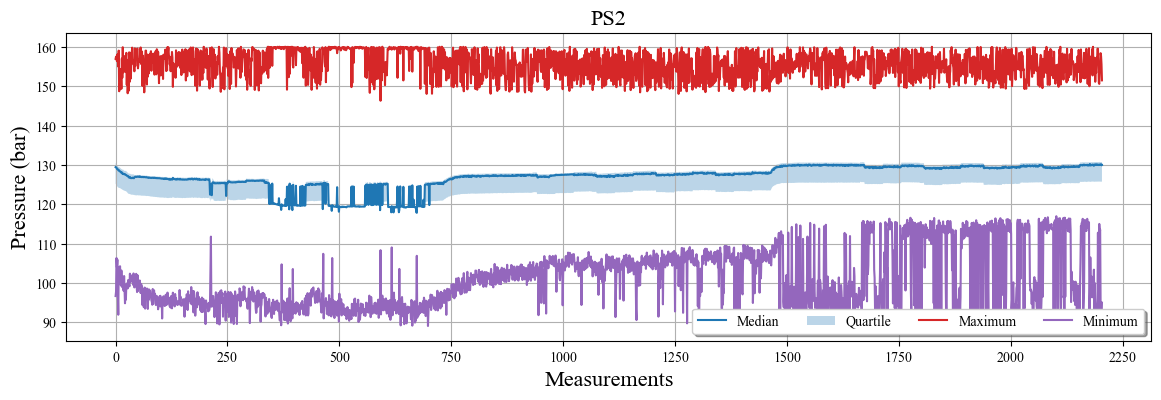

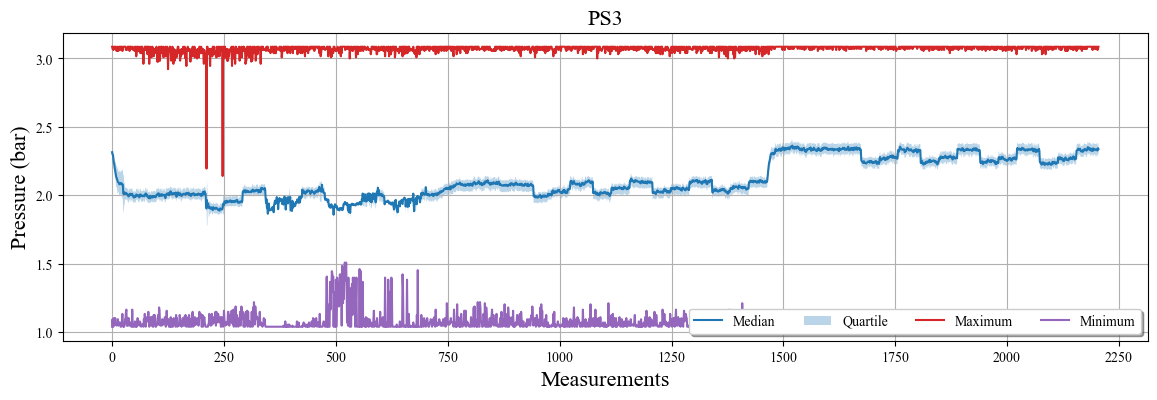

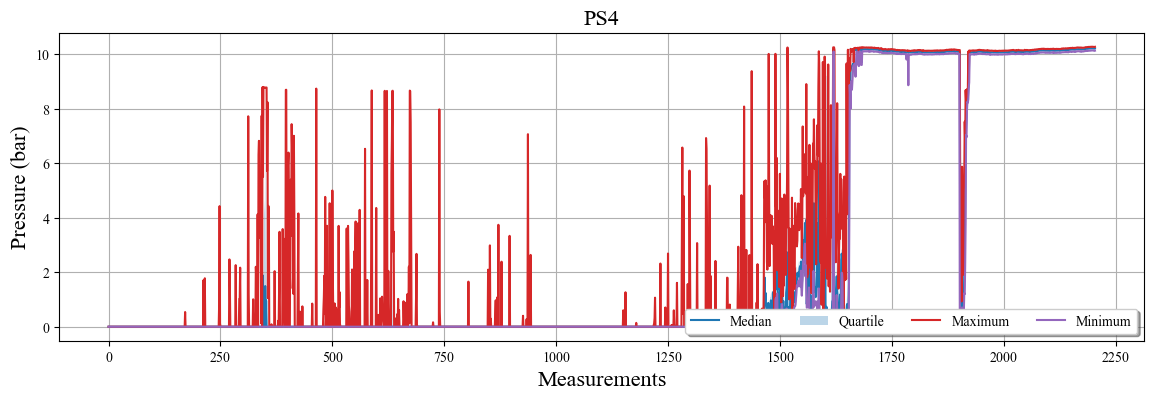

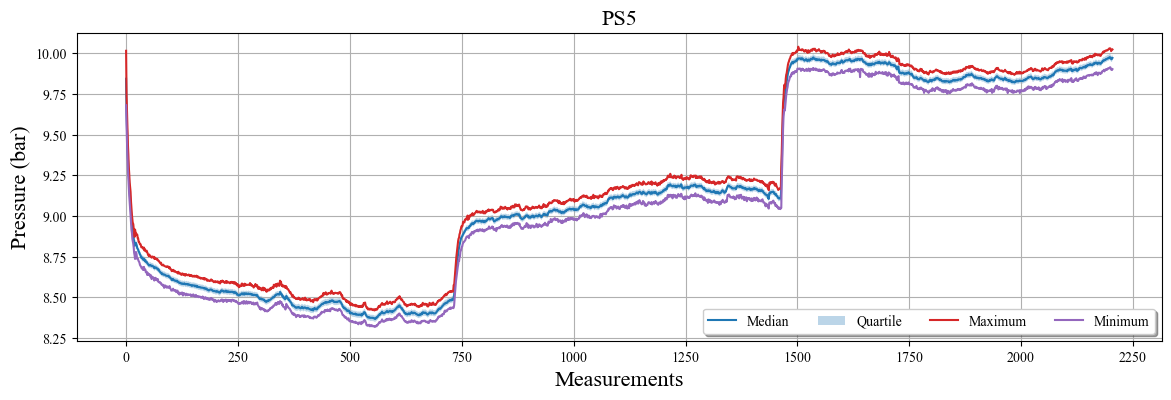

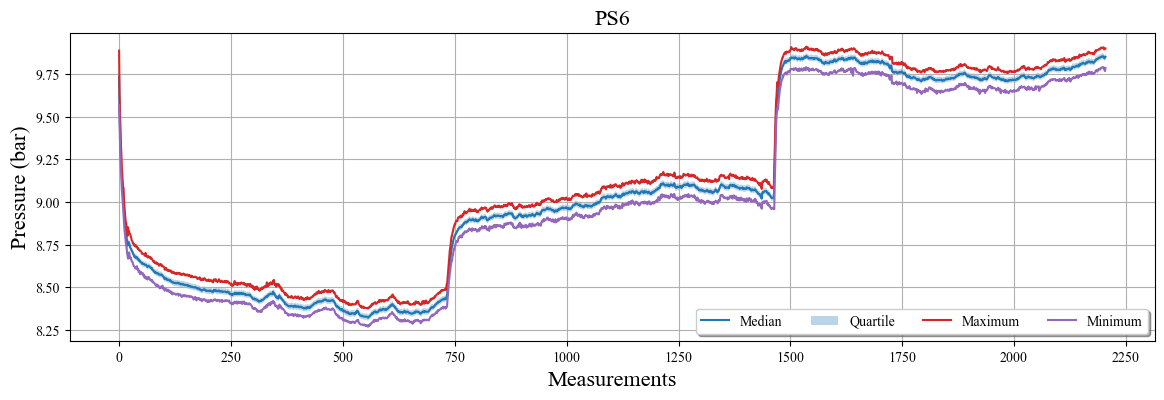

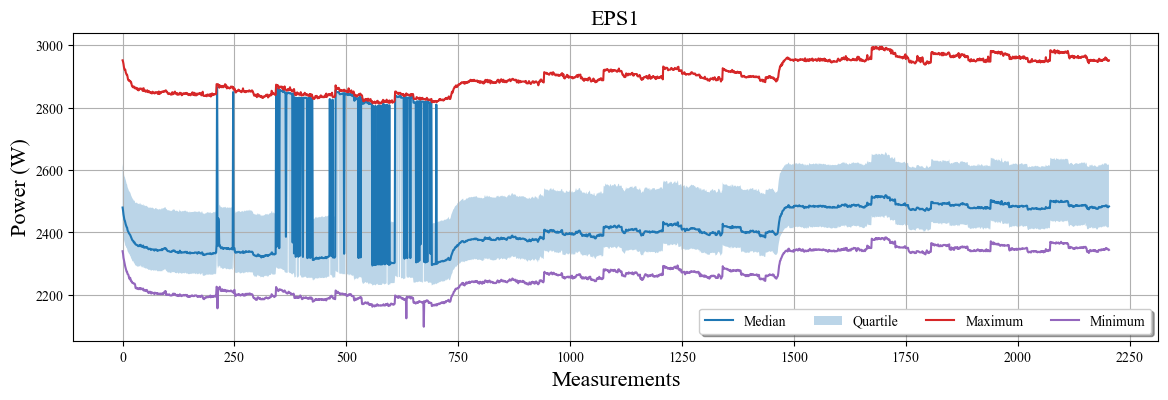

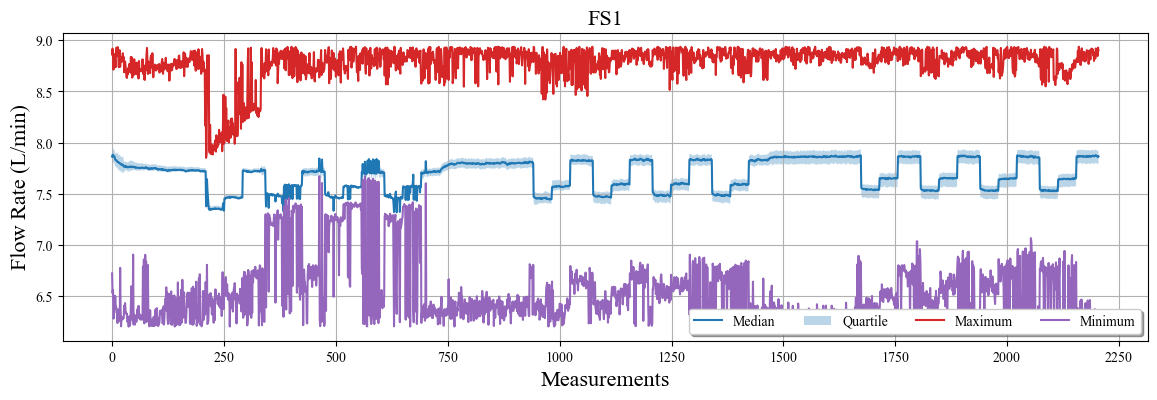

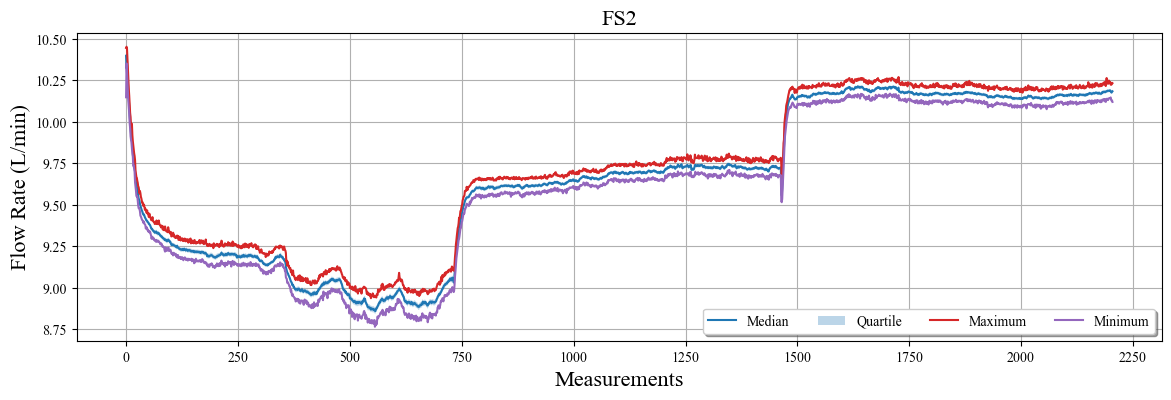

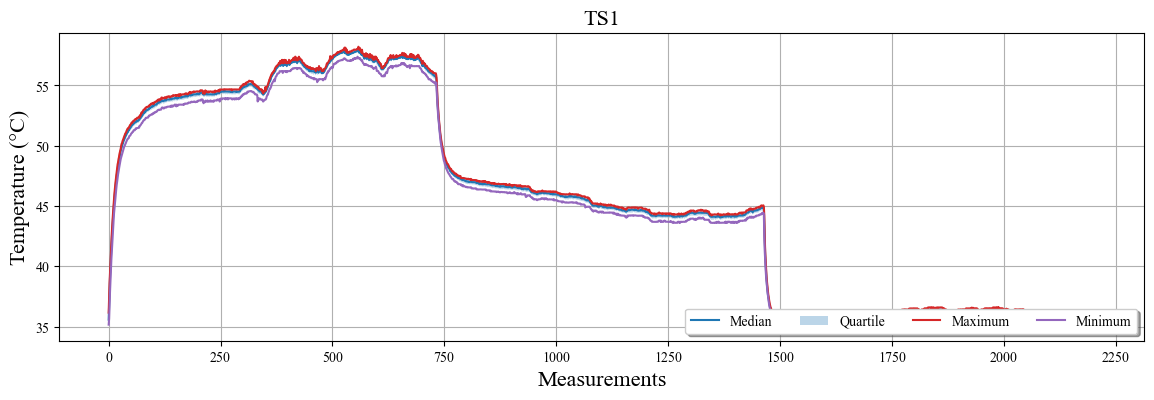

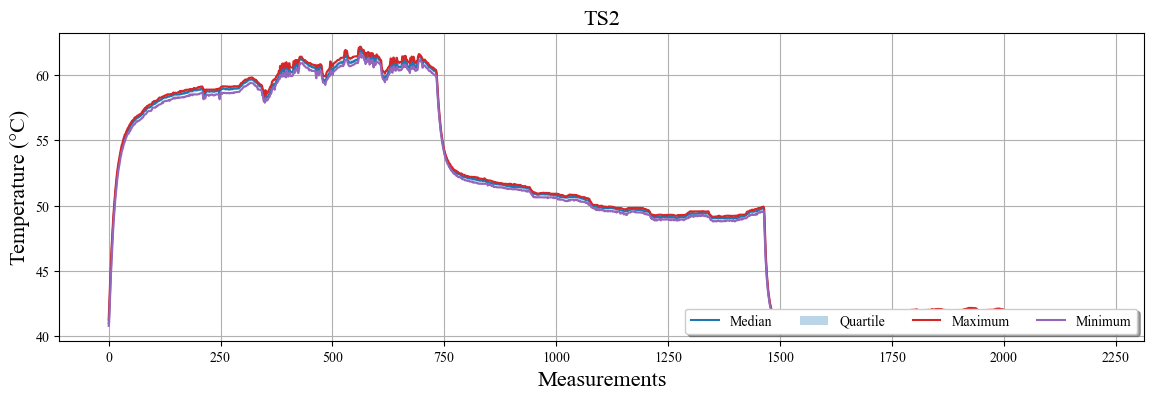

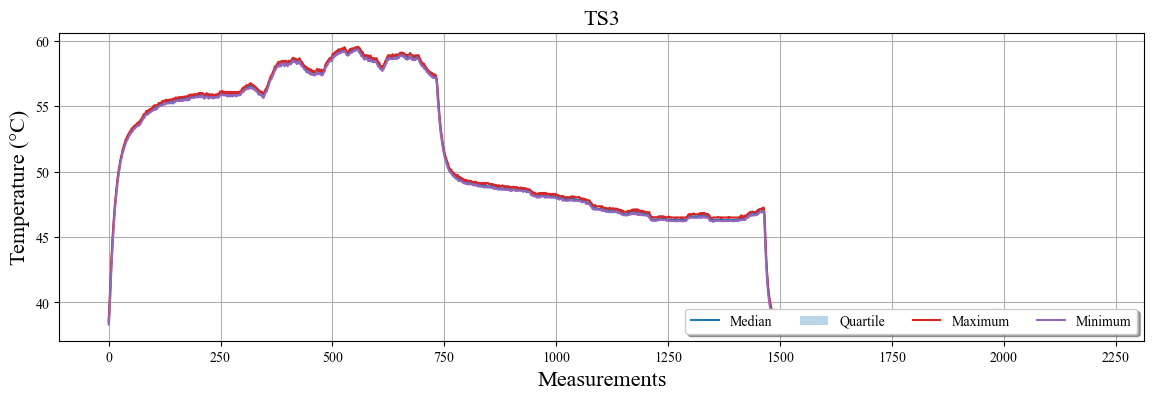

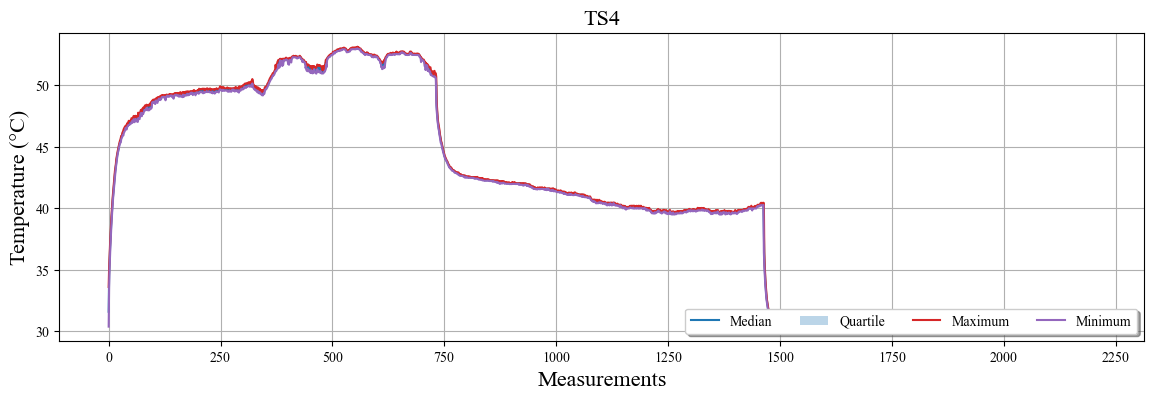

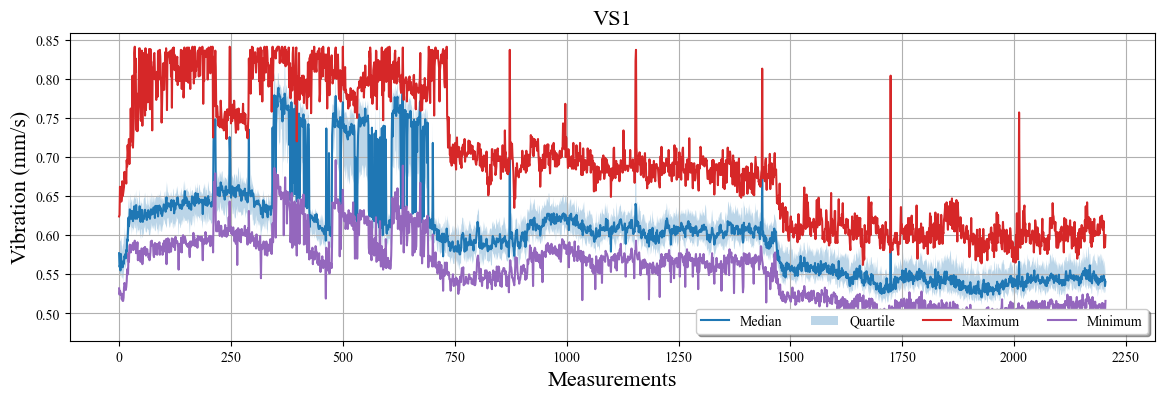

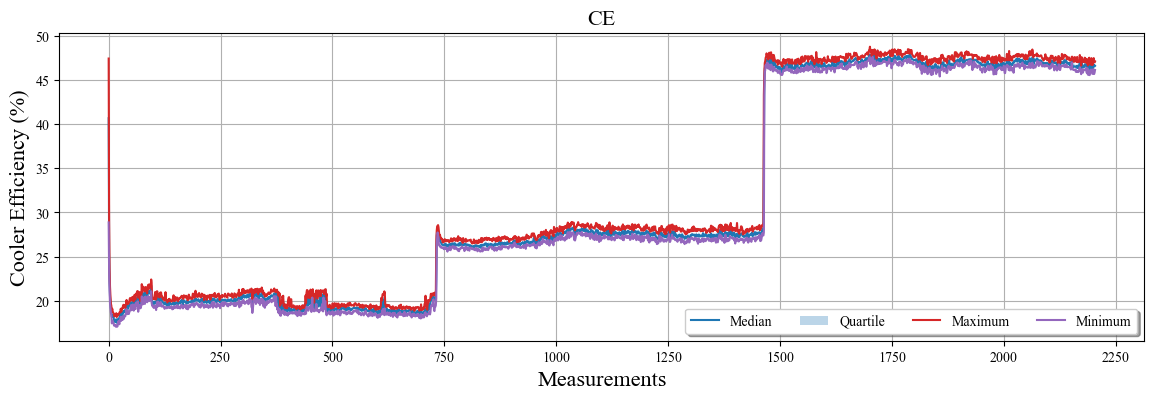

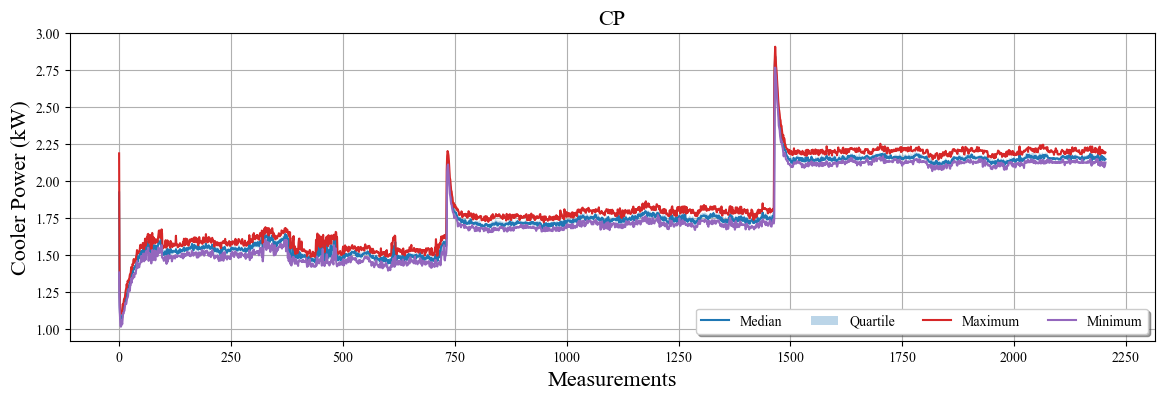

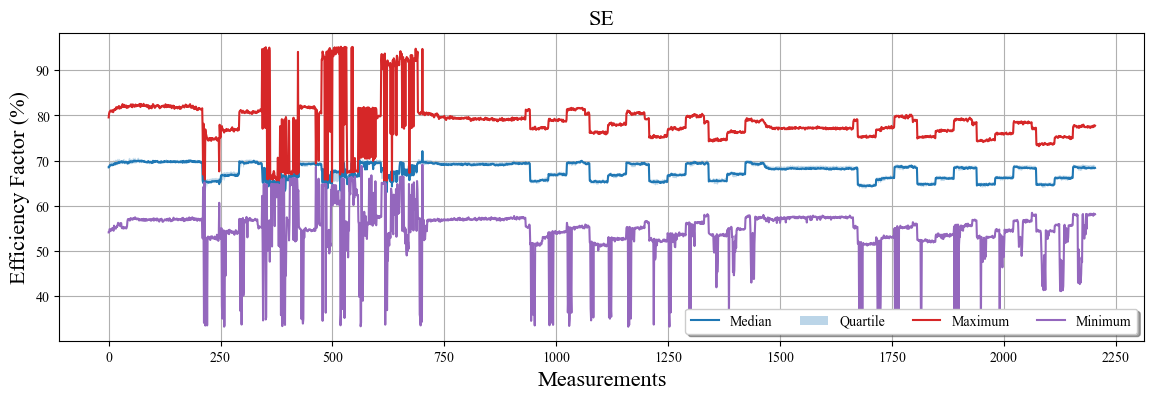

In [10]:
for c, u in zip(X_dict.keys(), ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)','Power (W)',
                                'Flow Rate (L/min)', 'Flow Rate (L/min)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)','Vibration (mm/s)', 'Cooler Efficiency (%)', 'Cooler Power (kW)', 'Efficiency Factor (%)']):
    descplot(X_dict[c], c, u)

In [ ]:
# for c, u in zip(X_dict.keys(), ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)','Power (W)',
#                                 'Flow Rate (L/min)', 'Flow Rate (L/min)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)', 'Temperature (°C)','Vibration (mm/s)', 'Cooler Efficiency (%)', 'Cooler Power (kW)', 'Efficiency Factor (%)']):
#     descplot_2(X_dict[c], c, u, X_profile)

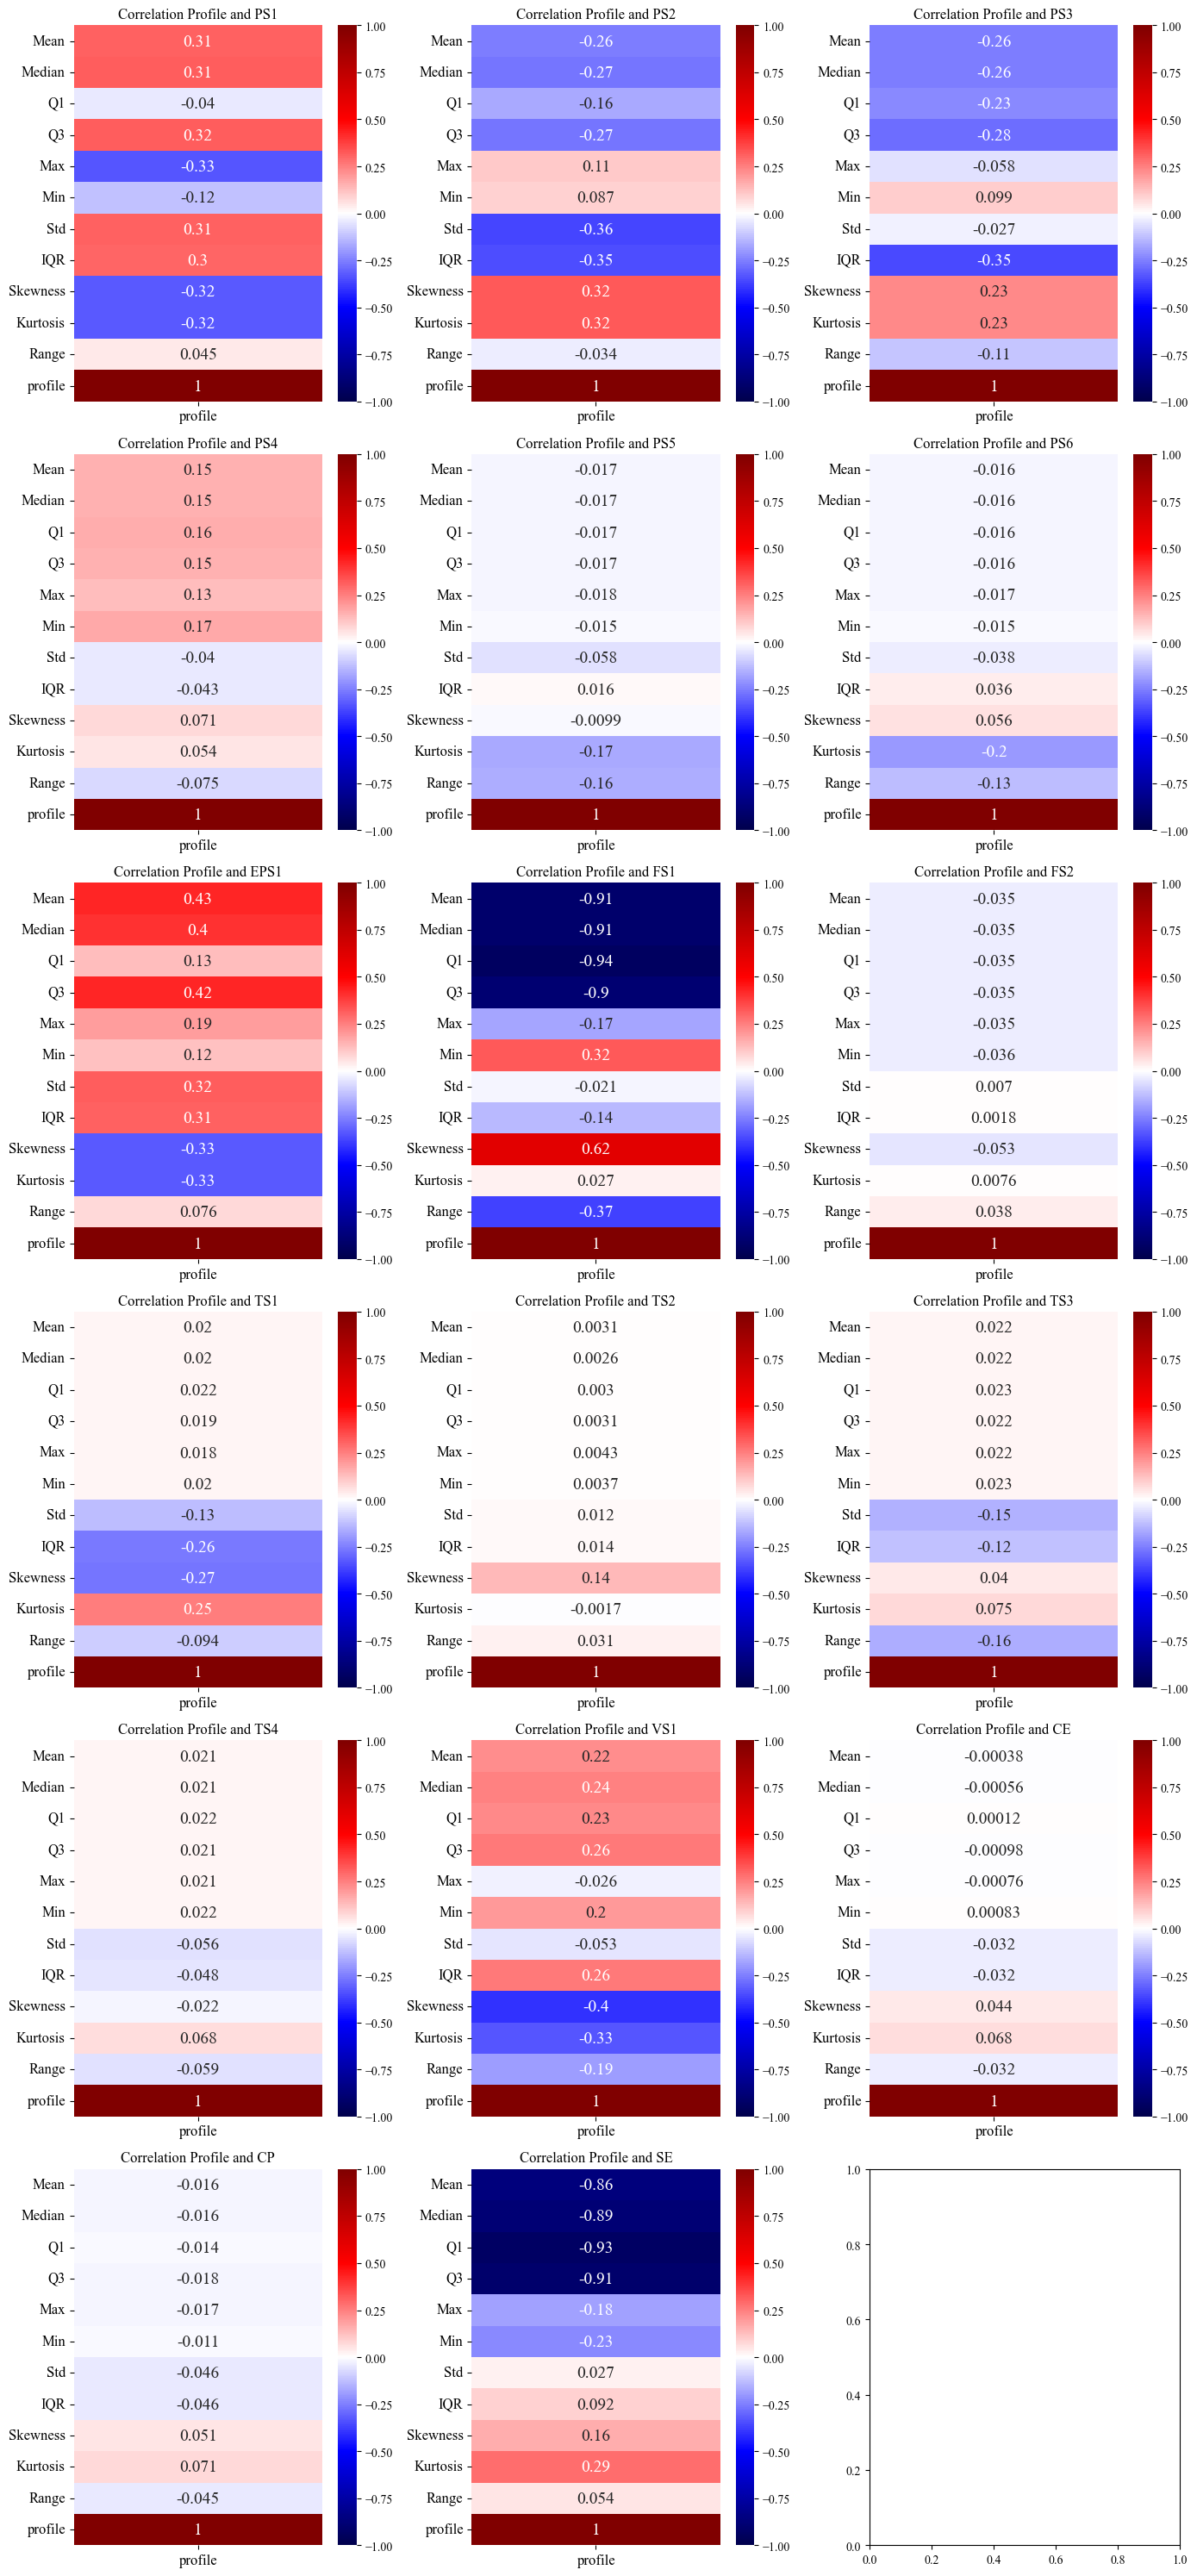

In [10]:
fig, axs = plt.subplots(6, 3, figsize=(14, 30))
for (k,v), ax in zip(X_dict.items(), axs.reshape(-1)):
    sns.heatmap(v.assign(profile=X_profile).corr()[['profile']], vmin=-1, vmax=1, annot=True, cmap='seismic', annot_kws={"size": 14}, ax=ax)
    ax.set_title('Correlation Profile and ' + k, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
plt.tight_layout()
plt.show()

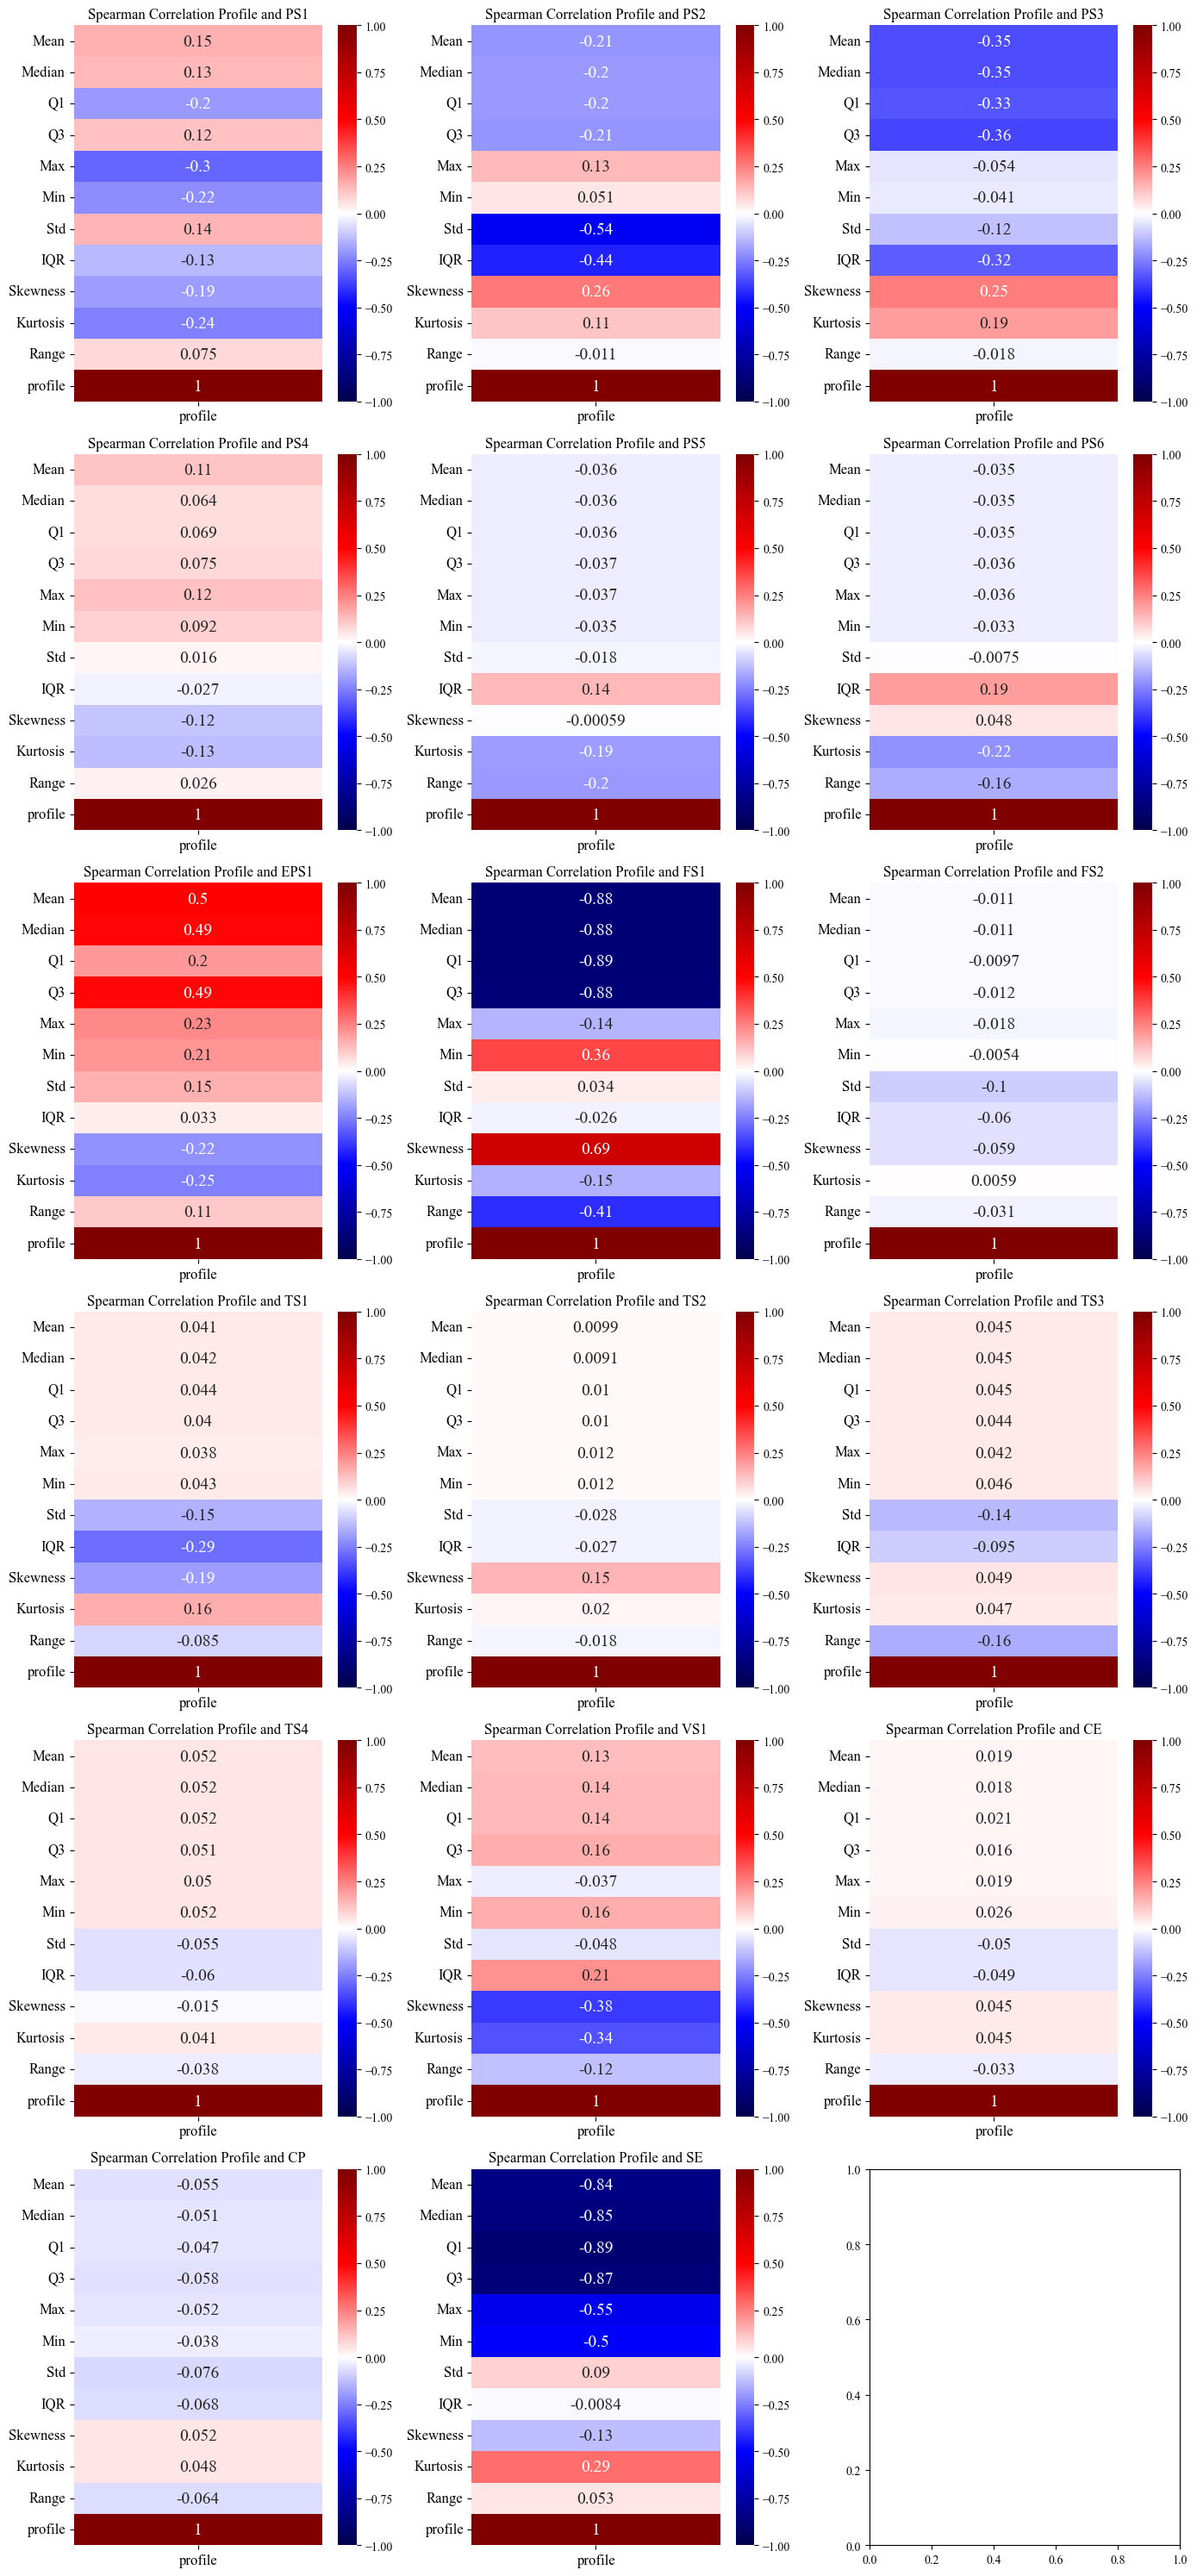

In [11]:
fig, axs = plt.subplots(6, 3, figsize=(14, 30))

for (k, v), ax in zip(X_dict.items(), axs.reshape(-1)):
    sns.heatmap(v.assign(profile=X_profile).corr(method='spearman')[['profile']], 
                vmin=-1, vmax=1, annot=True, cmap='seismic', annot_kws={"size": 14}, ax=ax)
    ax.set_title('Spearman Correlation Profile and ' + k, fontsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

In [ ]:
processed_dir = os.path.join(current_dir, '../data/processed/features')

In [ ]:
def save_to_parquet(data_dict, directory):
    for key, data in data_dict.items():
        file_path = os.path.join(directory, f'{key}.parquet')
        data.columns = [str(col) for col in data.columns]  # Ensure column names are strings
        data.to_parquet(file_path, index=False)
    
        
save_to_parquet(X_dict, processed_dir)
print('\nData saved to parquet format\n')